In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 90% 73.0M/80.9M [00:00<00:00, 109MB/s]
100% 80.9M/80.9M [00:00<00:00, 117MB/s]


In [ ]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
import re
import nltk
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", header=None)
df.columns = ["sentiment", "id", "date", "flag", "user", "text"]
df['sentiment'] = df['sentiment'].map({0:"Negative", 4:"Positive"})
df.head()

,sentiment,id,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df = df[['sentiment','text']]
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df['sentiment'].unique()

array(['Negative', 'Positive'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  object
 1   text       1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


In [ ]:
df.shape

(1600000, 2)

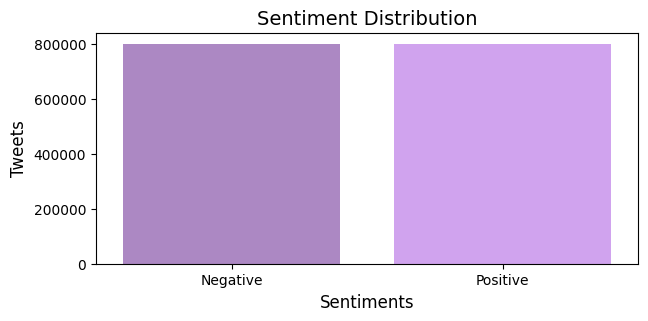

In [ ]:
plt.figure(figsize=(7,3))
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')
sns.countplot(data=df, x='sentiment', palette=[colors[7], colors[9]])
plt.xlabel("Sentiments", size=12)
plt.ylabel('Tweets', size=12)
plt.title("Sentiment Distribution", size=14)
plt.show()

In [ ]:
random_index = [random.randint(0, df.shape[0]) for i in range(10)]
for i in df['text'].loc[random_index]:
    print(i)

so there I was right... about to just tear it up when all of a sudden I woke up and the puppy petting festival was gone...  rofl
Showered and getting ready for work.  fail.
@pewgrim So long not my bank 
paid vacation time over  I'll be ready to caffeinate you in Eden Prairie from 5am-10am tomorrow. then I will pass out. goodnight.
@Deltachild if you go to silverstone I'm going to have to actually hate you 
thats wierd.... oh well, off to school.. my neck still hurts i should get it checked out soon. oh well follow me? 
@mojoe182  Dont blow up precious ! 
This weekend has been absolutely amazing and one of the best ever. 
Been sitting in garden with my mummy and also got a text from the boy who i thought had GOT THE HINT    obviously not.
@2330Becky It sounds like a lovely place to live.  Have you always lived where you live?


In [ ]:
mention_pattern = r'@\S+|#\S+'
url_pattern = r"https?:(?:www\.)?\S+"
non_alphanumeric_pattern = r"[^A-Za-z0-9\s]+"

In [ ]:
def data_cleaning(text):
    lower_text = str.lower(text)
    clean_text = re.sub(mention_pattern + '|' + url_pattern + '|' + non_alphanumeric_pattern, ' ', lower_text)
    return clean_text

In [ ]:
df['text'] = df['text'].apply(data_cleaning)

In [ ]:
from tqdm import tqdm
import nltk
nltk.download('punkt')
tqdm.pandas()

# Apply word_tokenize with a progress bar
df['tokenized text'] = df['text'].progress_apply(lambda document: word_tokenize(document.strip()))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
100%|██████████| 1600000/1600000 [03:39<00:00, 7287.48it/s]


In [ ]:
nltk.download('stopwords')

# Getting list of stopwords
stop_words = set(stopwords.words('english'))

# Removing all Stopwords
df['clean_tokens'] = df['tokenized text'].progress_apply(lambda tokens: [token for token in tokens if token not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 1600000/1600000 [00:10<00:00, 149842.08it/s]


In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [ ]:
# Appling Lemmatization on Clean Tokens
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')

# Applying Lemmatization
df['lemmatized text'] = df['clean_tokens'].progress_apply(lambda tokens: ' '.join([lemmatizer.lemmatize(token, pos='v') for token in tokens]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
100%|██████████| 1600000/1600000 [01:08<00:00, 23494.16it/s]


In [ ]:
# Filter out positive and negative sentiment data
positive = df[df['sentiment'] == 'Positive']['lemmatized text']
negative = df[df['sentiment'] == 'Negative']['lemmatized text']

# Combine text data into single strings
positive_data = " ".join(positive)
negative_data = " ".join(negative)

# Create WordCloud objects
wc_positive = WordCloud(max_words=500, width=1200, height=800, background_color='white', colormap='viridis',
              contour_color='black', contour_width=1, collocations=False, random_state=42).generate(positive_data)

wc_negative = WordCloud(max_words=500, width=1200, height=800, background_color='white', colormap='plasma',
              contour_color='black', contour_width=1, collocations=False, random_state=42).generate(negative_data)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Plot positive sentiment word cloud
axes[0].imshow(wc_positive, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Positive Sentiment Word Cloud", fontsize=24, fontweight='bold')

# Plot negative sentiment word cloud
axes[1].imshow(wc_negative, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Negative Sentiment Word Cloud", fontsize=24, fontweight='bold')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df['no_of_charcters'] = df['lemmatized text'].progress_apply(len)
df['no_of_words'] = df['lemmatized text'].progress_apply(lambda document: word_tokenize(document)).apply(len)

100%|██████████| 1600000/1600000 [03:17<00:00, 8093.71it/s] 


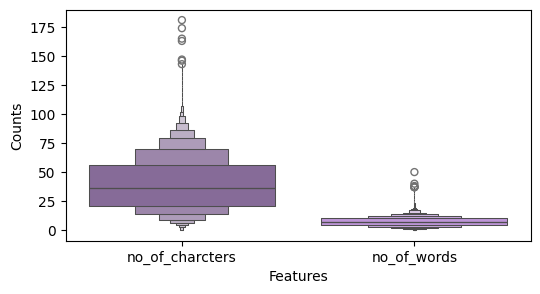

In [ ]:
plt.figure(figsize=(6,3))
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')
sns.boxenplot(df[['no_of_charcters', 'no_of_words']], palette=[colors[5], colors[8]])
plt.xlabel("Features")
plt.ylabel("Counts")
plt.show()

In [ ]:
df = df[(df['no_of_charcters']<100) & (df['no_of_words']<20)]


In [ ]:
X = df['lemmatized text']
y = df['sentiment'].map({"Negative":0, "Positive":1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(tqdm(X_train, desc="Vectorizing Text"))

Vectorizing Text: 100%|██████████| 1191448/1191448 [00:23<00:00, 51548.04it/s]


TfidfVectorizer(ngram_range=(1, 2))

In [ ]:
X_train = vectorizer.transform(tqdm(X_train))
X_test = vectorizer.transform(tqdm(X_test))

100%|██████████| 397150/397150 [00:08<00:00, 48227.69it/s]


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB()
}

model_performance = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred, average='weighted')
    precision = precision_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    model_performance[model_name] = {
        "Training Accuracy": training_accuracy,
        "Testing Accuracy": testing_accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1 Score": f1
    }

    print(f"Model: {model_name}")
    print(f"Training Accuracy: {training_accuracy}")
    print(f"Testing Acciracy: {testing_accuracy}")
    print("--"*20)

Model: Logistic Regression
Training Accuracy: 0.8543201213985
Testing Acciracy: 0.7887196273448319
----------------------------------------
Model: Naive Bayes
Training Accuracy: 0.8922982790688305
Testing Acciracy: 0.7724814301901045
----------------------------------------


In [ ]:
df_performance = pd.DataFrame(model_performance).T
df_performance.reset_index(inplace=True)
df_performance.rename(columns={'index': 'Model'}, inplace=True)
df_performance.style.background_gradient(cmap='Purples')

,Model,Training Accuracy,Testing Accuracy,Recall,Precision,F1 Score
0,Logistic Regression,0.854320,0.788720,0.788720,0.788764,0.788709
1,Naive Bayes,0.892298,0.772481,0.772481,0.773099,0.772362


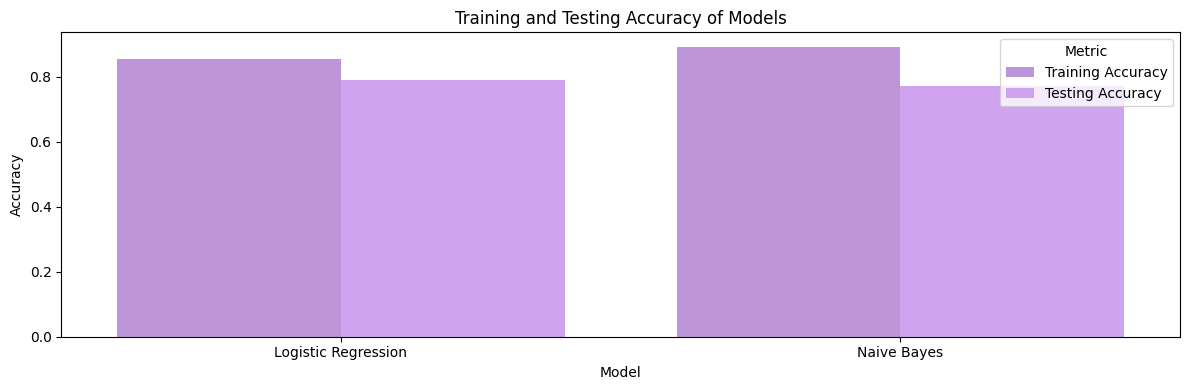

In [ ]:
df_melted = df_performance.melt(id_vars='Model', value_vars=['Training Accuracy', 'Testing Accuracy'],
                                var_name='Metric', value_name='Score')

# Plot training and testing accuracy
plt.figure(figsize=(12, 4))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette=[colors[8], colors[9]])
plt.title('Training and Testing Accuracy of Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Save each model
for model_name, model in models.items():
    filename = f"{model_name.replace(' ', '_')}_model.pkl"
    joblib.dump(model, filename)
    print(f"Saved {model_name} to {filename}")


Saved Logistic Regression to Logistic_Regression_model.pkl
Saved Naive Bayes to Naive_Bayes_model.pkl


In [ ]:
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']